In [36]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import glob
import os, sys
import h5py
import sigpy as sp
from trajectory_creator import Cart2D_traj_gen, prop2D_traj_gen
from motion_ops import motion_adjoint, motion_forward, motion_normal

os.environ["TOOLBOX_PATH"] = "/home/blevac/misc/HW/bart-0.6.00"  ## change to YOUR path
sys.path.append("/home/blevac/misc/HW/bart-0.6.00/python")        ## change to YOUR path
os.environ["OMP_NUM_THREADS"] = "1"
from bart import bart

from CG_motion import conjgrad_motion_nufft


## Load kspace and coil maps

In [3]:
device = 'cuda'
ksp_folder = sorted(glob.glob('/csiNAS/mridata/fastmri_brain/brain_multicoil_val/multicoil_val/multicoil_val/*T2*.h5'))

sample_num = 0
ksp_file = ksp_folder[sample_num]
print(ksp_file)

slic = 2
with h5py.File(ksp_file,'r') as cont:
    # print(cont.keys())
    ksp = np.asarray(cont['kspace'][slic])


/csiNAS/mridata/fastmri_brain/brain_multicoil_val/multicoil_val/multicoil_val/file_brain_AXT2_200_2000019.h5


## Reformat synthetic data to (384x384)

In [4]:
np_gt_coil_imgs = sp.resize(sp.ifft(ksp,axes=(-2,-1)), (ksp.shape[0],384,384))[None,...]
np_gt_coil_ksp  = sp.fft(np_gt_coil_imgs, axes = (-2,-1))
gt_coil_imgs    = torch.tensor(np_gt_coil_imgs)
print(gt_coil_imgs.shape)

torch.Size([1, 16, 384, 384])


## Calculate coil maps

---------------------------------------------
| CTR1 | CTR2 |  Crop  |      Est. MSE      |
---------------------------------------------
|    1 |    1 | 0.9900 | 1.927453013195e-05 |
|      |    2 | 0.8900 | 1.256466930499e-05 |
|      |    3 | 0.7900 | 1.227569282491e-05 |
|      |    4 | 0.6900 | 1.219945716002e-05 |
|      |    5 | 0.5900 | 1.233620150742e-05 |
|    2 |    1 | 0.6400 | 1.224924653798e-05 |
|      |    2 | 0.6900 | 1.219945716002e-05 |
|      |    3 | 0.7400 | 1.214754593093e-05 |
|      |    4 | 0.7900 | 1.227569282491e-05 |
|    3 |    1 | 0.7650 | 1.217829230882e-05 |
|      |    2 | 0.7400 | 1.214754593093e-05 |
|      |    3 | 0.7150 | 1.218035868078e-05 |
|    4 |    1 | 0.7275 | 1.216139935423e-05 |
|      |    2 | 0.7400 | 1.214754593093e-05 |
|      |    3 | 0.7525 | 1.215208430949e-05 |
|    5 |    1 | 0.7463 | 1.214734584210e-05 |
|      |    2 | 0.7400 | 1.214754593093e-05 |
|    6 |    1 | 0.7431 | 1.214754411194e-05 |
|      |    2 | 0.7462 | 1.2147345

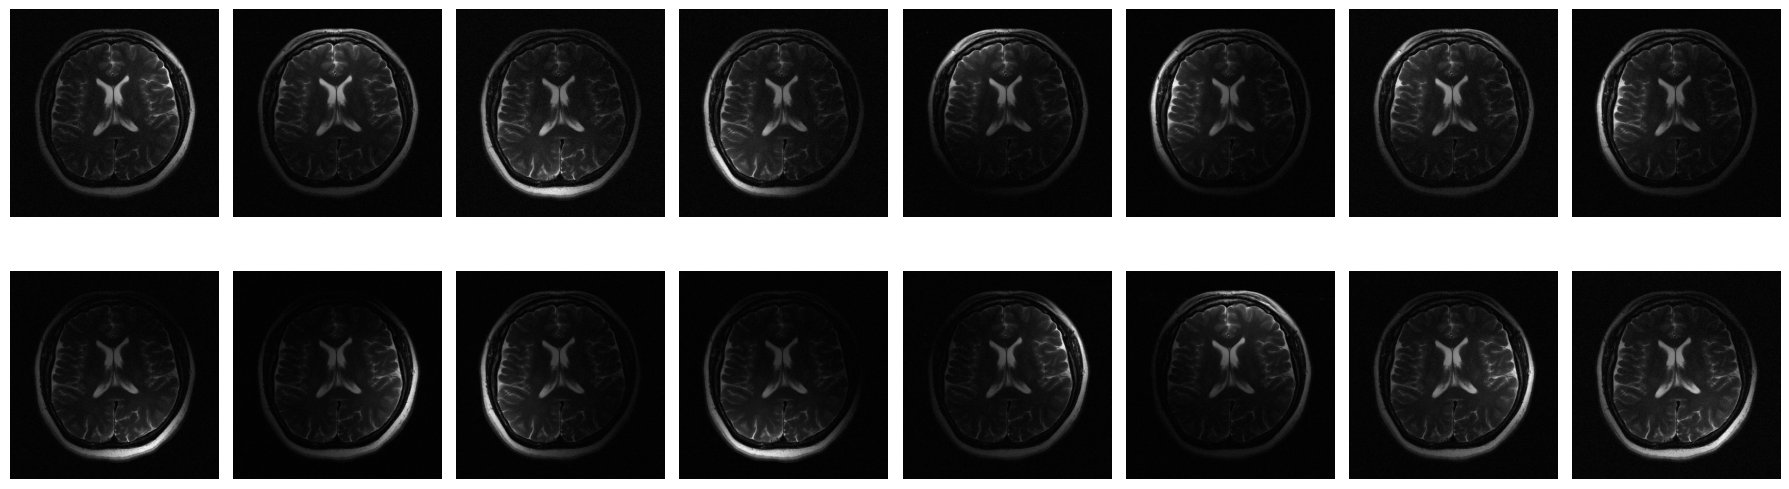

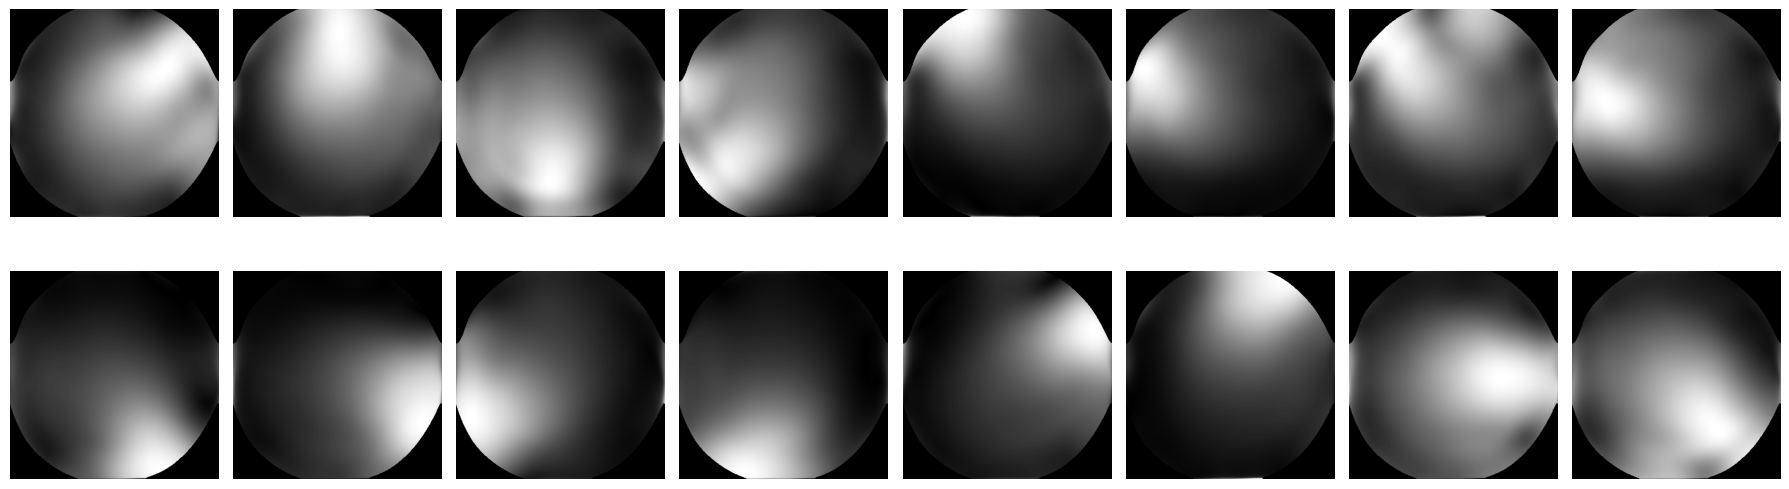

In [5]:
#generate new maps off of cropped ksp
np_gt_coil_ksp = np.transpose(np_gt_coil_ksp,(-2,-1,0,1))
sens = bart(1, 'ecalib -m 1 -a', np_gt_coil_ksp) #requires data of the form (Row,Column,None,Coil)<-output of ecalib too, this should then be saved (slice, coil, rows, columns)
new_maps = torch.tensor(sens).permute(-2,-1,0,1)


plt.figure(figsize=(18,6))
for i in range(gt_coil_imgs.shape[1]):
    plt.subplot(2,8,i+1)
    plt.imshow(torch.flipud(abs(gt_coil_imgs[0,i])),cmap='gray')
    plt.axis('off')

plt.tight_layout()


plt.figure(figsize=(18,6))
for i in range(gt_coil_imgs.shape[1]):
    plt.subplot(2,8,i+1)
    plt.imshow(torch.flipud(abs(new_maps[0,i])),cmap='gray')
    plt.axis('off')

plt.tight_layout()

## Create motion states and aquisition trajectory

In [57]:
#Generate GT image
R = 2
TRs = 48
ETL = 8
max = 3.0
coords = Cart2D_traj_gen(TRs=TRs, ETL=ETL, N_RO=384, ro_dir='x', ordering='interleave')
ktraj = torch.tensor(coords[0::R]).to(device)


gt_coil_imgs = gt_coil_imgs.to(device)
gt_dx = torch.tensor(np.random.uniform(-max,max,int(TRs/R))).to(device)
gt_dy = torch.tensor(np.random.uniform(-max,max,int(TRs/R))).to(device)
gt_theta = torch.tensor(np.random.uniform(-max,max,int(TRs/R))).to(device)
maps = new_maps.to(device)
init_maps = torch.ones(gt_coil_imgs.shape).to(device)

# generate motion corrupt measuremnts
y_meas    = motion_forward(image = gt_coil_imgs, s_maps = init_maps, coords = ktraj, angles=gt_theta, dx = gt_dx, dy = gt_dy, device=device)

Text(0, 0.5, 'ky')

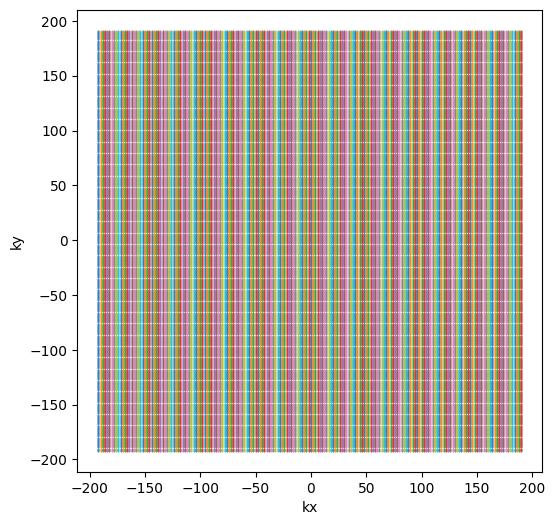

In [58]:
# vizualize sampling patterns
plt.figure(figsize=(6,6))
for i in range(ktraj.shape[0]):
    plt.scatter(ktraj[i,:,1].cpu(), ktraj[i,:,0].cpu(),s=0.2 )

plt.xlabel('kx')
plt.ylabel('ky')

## Do adjoint recon without accounting for motion

In [59]:
adj_moco_img = motion_adjoint(ksp = y_meas,coords=ktraj, s_maps = maps, angles=torch.zeros_like(gt_theta),dx = torch.zeros_like(gt_dx), dy = torch.zeros_like(gt_dy),img_shape=maps.shape,device=device)

(-0.5, 383.5, 383.5, -0.5)

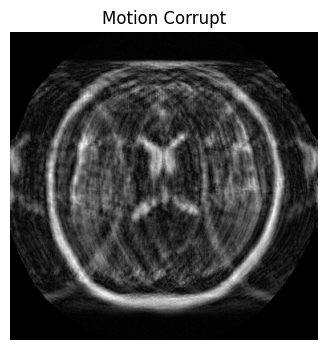

In [60]:
plt.figure(figsize=(4,4))
plt.title('Motion Corrupt')
plt.imshow(torch.flipud(abs(adj_moco_img.cpu())[0,0]),cmap='gray')
plt.axis('off')

## Do CG based Recons

Note: accounting for motion in the Forward/Adjoint hurts the condition number so convergence is slower for the recon with correct motion estimates. If you're curious just calculate the condition number using power iteration

In [61]:
# Do recon with known motion states
rhs =  motion_adjoint(ksp = y_meas,coords=ktraj, s_maps = maps, angles= gt_theta,dx = gt_dx, dy = gt_dy,img_shape=maps.shape,device=device)
rhs_scaled = rhs/torch.max(abs(rhs))
known_motion_cg, iter= conjgrad_motion_nufft(x=rhs_scaled, b=rhs_scaled, ktraj=ktraj, maps=maps, thetas=gt_theta, dx=gt_dx, dy=gt_dy, max_iter=100
                                , l2lam=.001, eps=1e-4, verbose=True, complex=True, device=device)

0: 34.1566300686801
1: 16.788256816039233
2: 9.53439646175527
3: 6.934800578197149
4: 3.337034352773886
5: 2.7410512567034684
6: 2.110386409341724
7: 1.5414949925649788
8: 1.4150288834196274
9: 0.9480834025026496
10: 0.7954038429970203
11: 0.703836028748244
12: 0.5878498922522951
13: 0.5023383500405272
14: 0.4242039818479335
15: 0.41904016974498426
16: 0.37670789435508284
17: 0.34581653359038445
18: 0.3488973064984967
19: 0.3097335577978022
20: 0.2927385359079674
21: 0.2564631276989127
22: 0.27047101240595406
23: 0.25556889575675346
24: 0.21680250926194983
25: 0.22222437639912382
26: 0.20724421056001469
27: 0.19524221199202635
28: 0.18629995901638471
29: 0.17756298799505948
30: 0.1741244718862509
31: 0.1633097986766633
32: 0.15986877113998813
33: 0.15150923207689568
34: 0.14652132760885014
35: 0.1411463604090718
36: 0.13170596478371271
37: 0.1329715289151412
38: 0.12210821592713653
39: 0.1183918177515574
40: 0.11367162392540231
41: 0.10838032710571988
42: 0.10437557610570619
43: 0.1009

In [62]:
# Do recon with unknown motion states
rhs =   motion_adjoint(ksp = y_meas,coords=ktraj, s_maps = maps, angles=torch.zeros_like(gt_theta),dx = torch.zeros_like(gt_dx), dy = torch.zeros_like(gt_dy),img_shape=maps.shape,device=device)
rhs_scaled = rhs/torch.max(abs(rhs))
unknown_motion_cg, iter= conjgrad_motion_nufft(x=rhs_scaled, b=rhs_scaled, ktraj=ktraj, maps=maps, thetas=torch.zeros_like(gt_theta), dx=torch.zeros_like(gt_dx), dy=torch.zeros_like(gt_dy), max_iter=100
                                , l2lam=.001, eps=1e-4, verbose=True, complex=True, device=device)

0: 39.528394772663866
1: 11.509626952574687
2: 3.706008562219237
3: 1.8180693091652413
4: 1.2256073864461736
5: 0.7182241207341521
6: 0.45072890080833705
7: 0.26372267730887716
8: 0.17435156107136976
9: 0.10088453716069389
10: 0.06932529165957697
11: 0.040806504004032865
12: 0.028196101323299857
13: 0.017200388351623023
14: 0.01171303379338862
15: 0.0070466739521789015
16: 0.004877451100197459
17: 0.0028925201553468144
18: 0.0020121736079836265
19: 0.0012000122806183752
20: 0.000820046986587458
21: 0.0004947822829520751
22: 0.0003366942831248617
23: 0.00020817433718339946
24: 0.00013919522934224105
25: 8.824351693689807e-05
FINAL: tensor([8.8244e-05], device='cuda:0', dtype=torch.float64)


(-0.5, 383.5, 383.5, -0.5)

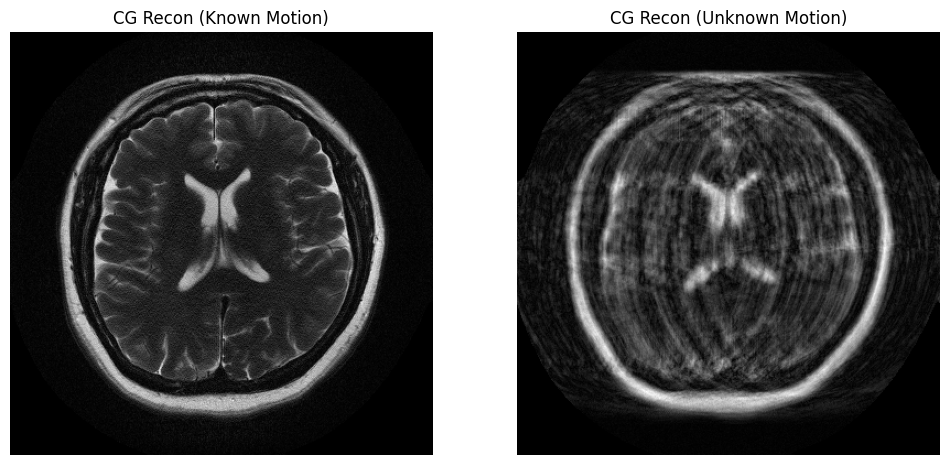

In [63]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('CG Recon (Known Motion)')
plt.imshow(torch.flipud(abs(known_motion_cg.cpu())[0,0]),cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title('CG Recon (Unknown Motion)')
plt.imshow(torch.flipud(abs(unknown_motion_cg.cpu())[0,0]),cmap='gray')
plt.axis('off')